The dataset used in this training is created by random shuffling of paths to create the validation and train set. `zstackexperiment_14112023_101-110` was used as the test set. It contains a lot of image augmentation and will be used as a base model. The base model will be fintuened with smaller learning rate to tune for better MAE.

In [1]:
import os
import time

import torch
import torchvision
import shutil
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.io import read_image, ImageReadMode

from PIL import Image, ImageDraw, ImageFont


## Configurations

In [ ]:
# Dataset paths, Adjust accordingly.
images_root = '/media/eyildiz/data/zstack_analys/cnn_dataset/0.1_training_data'
train_csv = images_root + '/train_targets.csv'
val_csv = images_root + '/val_targets.csv'
test_csv = images_root+ '/test_targets.csv'

#model train parameters
learning_rate = 1e-4
batch_size = 64
total_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing the Datasets

In [3]:
from enum import Enum
from typing import Optional, Union, List

class CacheStrategy(Enum):
    NO_CACHE = "no_cache"
    DISK_CACHE = "disk_cache"
    MEMORY_CACHE = "memory_cache"

class LoadDataset(Dataset):
    def __init__(
        self,
        path_csv: str,
        images_path: str,
        cache_strategy: Union[str, CacheStrategy] = CacheStrategy.MEMORY_CACHE,
        transforms: Optional[transforms.Compose] = None,
        img_size: int = 270,
        cache_dir: str = "cache"
    ):
        super().__init__()
        self.annots = pd.read_csv(path_csv)
        self.images_path = images_path
        self.transforms = transforms
        self.cache_dir = cache_dir
        self.img_size = img_size
        
        # Convert string to enum if necessary
        if isinstance(cache_strategy, str):
            cache_strategy = CacheStrategy(cache_strategy)
        self.cache_strategy = cache_strategy
        
        # Check for missing files
        self._check_missing_files(handle_missing='remove')
        
        # Initialize cache-related attributes
        self.cached_data = None
        self._setup_cache()
        
    def _setup_cache(self):
        """Set up caching based on the selected strategy"""
        if self.cache_strategy in [CacheStrategy.DISK_CACHE, CacheStrategy.MEMORY_CACHE]:
            if not os.path.exists(self.cache_dir):
                os.makedirs(self.cache_dir)
                
        if self.cache_strategy == CacheStrategy.MEMORY_CACHE:
            self.cached_data = self._load_or_cache()
    
    def _get_cache_path(self, index: int) -> str:
        """Get the cache file path for a given index"""
        return os.path.join(self.cache_dir, f"cached_{self.img_size}_{index}.pt")
    
    def _load_or_cache(self) -> List[torch.Tensor]:
        """Load all images into memory cache"""
        cached_data = []
        for i, img_path in enumerate(tqdm(self.annots.iloc[:, 0], desc='Caching Images to Memory')):
            cache_path = self._get_cache_path(i)
            
            if os.path.exists(cache_path):
                cached_data.append(torch.load(cache_path, weights_only=False))
            else:
                img = self._load_and_process_image(img_path)
                if self.cache_strategy != CacheStrategy.NO_CACHE:
                    torch.save(img, cache_path)
                cached_data.append(img)
                
        return cached_data
    
    def _load_and_process_image(self, img_path: str) -> torch.Tensor:
        """Load and process a single image"""
        img_path_full = os.path.join(self.images_path, img_path)
        try:
            img = Image.open(img_path_full)
            img = transforms.functional.resize(img, self.img_size, interpolation=transforms.InterpolationMode.BICUBIC)
            return img
        except FileNotFoundError:
            print(f"Image not found at path: {img_path_full}")
            raise
    
    def _get_image(self, index: int) -> torch.Tensor:
        """Get image based on caching strategy"""
        if self.cache_strategy == CacheStrategy.MEMORY_CACHE:
            return self.cached_data[index]
        
        elif self.cache_strategy == CacheStrategy.DISK_CACHE:
            cache_path = self._get_cache_path(index)
            if os.path.exists(cache_path):
                return torch.load(cache_path, weights_only=False)
            else:
                img = self._load_and_process_image(self.annots.iloc[index, 0])
                torch.save(img, cache_path)
                return img
                
        else:  # NO_CACHE
            return self._load_and_process_image(self.annots.iloc[index, 0])
    
    def __len__(self) -> int:
        return len(self.annots)
    
    def __getitem__(self, index: int) -> tuple:
        img = self._get_image(index)
        target = torch.tensor(self.annots.iloc[index, 1], dtype=torch.float)
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, target
    
    def visualize(self, idx: int) -> None:
        """Visualize a single image with its target value"""
        img, target = self.__getitem__(idx)
        if isinstance(img, torch.Tensor):
            tensor_to_pil = transforms.ToPILImage()
            img = tensor_to_pil(img)
        draw = ImageDraw.Draw(img)
        text = f'Offset = {target.item():.3f}'
        font = ImageFont.load_default()
        draw.text((30, 20), text, font=font)
        return img
        
    
    def _check_missing_files(self, handle_missing: str = 'log') -> List[str]:
        """Check for missing image files and handle them based on the provided method"""
        missing_files = []
        
        for idx, row in self.annots.iterrows():
            img_path = row.iloc[0]
            full_path = os.path.join(self.images_path, img_path)
            if not os.path.exists(full_path):
                missing_files.append(full_path)
                print(f"Missing file: {full_path}")
        
        if handle_missing == 'remove' and missing_files:
            self.annots = self.annots[~self.annots.iloc[:, 0].isin([os.path.relpath(f, self.images_path) for f in missing_files])]
            self.annots.reset_index(drop=True, inplace=True)
            print(f"Removed {len(missing_files)} missing file entries from the dataset.")
        
        return missing_files

In [4]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode


# Data transformations
data_transforms = {
    'train': transforms.Compose([
        # Geometric augmentations with RandomChoice

        transforms.RandomAffine(
            degrees=(-15, 15),
            translate=(0.4, 0.1),
            fill=2,
            interpolation = InterpolationMode.BILINEAR
        ),

        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        
        # Color augmentations
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        
        # Conversion and normalization
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0331], std=[0.0228]),  # Calculated on this dataset
        transforms.RandomErasing(p = 0.65, scale = (0.01, 0.05))
    ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0331], std=[0.0228]),  # Calculated on this dataset
    ]),
}


In [5]:
# Load the dataset with specified transformations
root_path = images_root

trainset = LoadDataset(
    train_csv,
    root_path,
    transforms=data_transforms['train'],
    cache_dir="cache_train"
)

valset = LoadDataset(
    test_csv,
    root_path,
    transforms=data_transforms['test'],
    cache_dir="cache_val"
)

Caching Images to Memory: 100%|██████████| 3212/3212 [00:21<00:00, 149.83it/s]


In [6]:
print('Image shapes: ', trainset[0][0].shape)

Image shapes:  torch.Size([1, 270, 320])


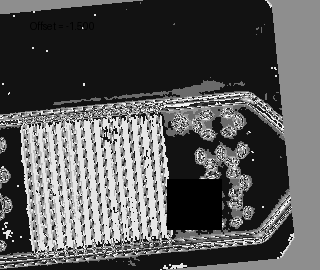

In [7]:
idx = torch.randint(0, len(trainset), size = (1, 1))
img = trainset.visualize(idx[0].item())
img

## Preparing Dataloaders

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)



                                     
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)





dataset_size = [len(trainset), len(valset)]



dataloaders= {
    "train": trainloader,
    "val": valloader
}

dataset_sizes = {
    "train": dataset_size[0],
    "val": dataset_size[1]
}

print('Size of datasets:', dataset_sizes)

Size of datasets: {'train': 28904, 'val': 3212}


## Model Architecture Defination
I will be using eficcientNetv2 small for intial testing and training of the data and developing network.

In [13]:
import torchvision
import torch.nn as nn


class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(
                out_channels,
                eps=0.001,
                momentum=0.1,
                affine=True,
                track_running_stats=True,
            ),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)


class ImageRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = self._init_feature_extractor()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()

        self.regression_head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        features = self.feature_extractor(img)  # Output: [batch_size, 1280, H', W']
        features = self.avgpool(features)  # Output: [batch_size, 1280, 1, 1]
        features = self.flatten(features)  # Output: [batch_size, 1280]
        reg = self.regression_head(features)
        return reg

    def _init_feature_extractor(self, in_channels=1):
        base_network = torchvision.models.efficientnet_v2_s(weights=None)
        feature_extractor = base_network.features
        
        feature_extractor[0][0] = nn.Conv2d(
            1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        
        feature_extractor[0] = nn.Sequential(
            feature_extractor[0],
            Conv2dNormActivation(24, 24),
        )

        feature_extractor = nn.Sequential(
            feature_extractor[:2],
            feature_extractor[2][:2],
            feature_extractor[3][:2],
            feature_extractor[4][:3],
            feature_extractor[5][:2],
            feature_extractor[6][:4],
            feature_extractor[-1],
        )
        # ref:https://www.researchgate.net/figure/Efficientnet-v2-s-Architecture-a-represents-the-schematic-of-the-model-from-image-input_fig2_373782480
        # There are total 8 blocks, 2 conv3dNorm(at start and at end) and 3 fused mbconv , 3 mb conv
        return feature_extractor


In [14]:
model = ImageRegressor()

#test
inp = torch.randn((1, 1, 270, 320))

out = model(inp)
out.shape


torch.Size([1, 1])

## Training the Model

### Helper Functions for training and Evaluation

In [15]:
import torch
import torch.nn as nn
import time
import os
import shutil
from tqdm import tqdm
from typing import Dict, Any, Optional

def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    dataloaders: Dict[str, torch.utils.data.DataLoader],
    dataset_sizes: Dict[str, int],
    device: torch.device,
    num_epochs: int = 25,
    metric: nn.Module = nn.L1Loss(reduction='mean'),
    patience: int = 12,
    min_delta: float = 1e-4
) -> tuple[nn.Module, Dict[str, Any]]:
    """
    Train a PyTorch model with forward and backward propagation.
    
    Args:
        model: PyTorch model to train
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary containing size of 'train' and 'val' datasets
        device: Device to train on (cuda/cpu)
        num_epochs: Maximum number of epochs to train
        metric: Metric to track for model performance (default: MAE)
        patience: Number of epochs to wait before early stopping
        min_delta: Minimum change in monitored value to qualify as an improvement
        
    Returns:
        tuple: (best_model, training_history)
    """
    since = time.time()
    
    # Initialize epoch data storage
    epoch_data = {
        'epoch': [],
        'train': {'loss': [], 'MAE': []},
        'val': {'loss': [], 'MAE': []}
    }
    
    # Create temporary directory for model checkpoints
    tempdir = './temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
    # Save initial model state
    torch.save(model.state_dict(), best_model_params_path)
    
    best_mae = float('inf')
    no_improve_epochs = 0
    
    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            epoch_data['epoch'].append(epoch+1)
            
            # Training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_mae = 0.0
                
                # Iterate over data
                for inputs, targets in tqdm(dataloaders[phase], desc=f'{phase} phase'):
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    targets = targets.view(-1, 1)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    batch_size = inputs.size(0)
                    running_loss += loss.item() * batch_size
                    running_mae += metric(outputs, targets).item() * batch_size
                
                if phase == 'train':
                    scheduler.step()
                
                # Calculate epoch metrics
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_mae = running_mae / dataset_sizes[phase]
                
                # Store metrics
                epoch_data[phase]['loss'].append(epoch_loss)
                epoch_data[phase]['MAE'].append(epoch_mae)
                
                print(f'{phase} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')
                
                # Save best model
                if phase == 'val':
                    if epoch_mae < best_mae - min_delta:
                        best_mae = epoch_mae
                        torch.save(model.state_dict(), best_model_params_path)
                        no_improve_epochs = 0
                    else:
                        no_improve_epochs += 1
                        
            
            print()
            
            # Early stopping check
            if no_improve_epochs >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
                
    except KeyboardInterrupt:
        print('Training interrupted by user')
    
    finally:
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val MAE: {best_mae:4f}')
        
        # Load best model
        model.load_state_dict(torch.load(best_model_params_path, weights_only = True))
        
        # Clean up temporary directory
        shutil.rmtree(tempdir)
    
    return model, best_mae, epoch,  epoch_data, 

In [16]:
def evaluate_model(model, criterion , dataloader):
    model.eval()
    metric = nn.L1Loss()
    running_loss = 0.0
    running_mae = 0

    for inputs, targets in tqdm(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.view(-1, 1) 
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            running_mae += metric(outputs, targets).item()*inputs.size(0)

    eval_loss = running_loss / len(dataloader.dataset)
    eval_mae = running_mae / len(dataloader.dataset)

    print(f'Evaluation Loss: {eval_loss:.4f} Evaluation MAE: {eval_mae:.4f}')

    return eval_loss, eval_mae

In [17]:
class CustomLoss(nn.Module):
    def __init__(self, ratio = 0.6):
        super().__init__()
        self.ratio = ratio
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

    def forward(self, pred, targets):
        l1 = self.mse(pred, targets)
        l2 = self.mae(pred, targets)
        return self.ratio*l1 + (1-self.ratio)*l2

### Training the model 

In [18]:
## 
from torch import optim

model = ImageRegressor()
model = model.to(device)

criterion = CustomLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=learning_rate)


exp_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=[50,90], gamma=0.1)


model, best_mae, epoch, history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,device, num_epochs = total_epochs)


Epoch 1/120
----------


train phase: 100%|██████████| 226/226 [02:10<00:00,  1.74it/s]


train Loss: 2.2261 MAE: 1.2483


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.79it/s]


val Loss: 0.6436 MAE: 0.6187

Epoch 2/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.6742 MAE: 0.6462


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


val Loss: 0.4385 MAE: 0.4998

Epoch 3/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.5521 MAE: 0.5720


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.08it/s]


val Loss: 0.4496 MAE: 0.4975

Epoch 4/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.4991 MAE: 0.5375


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.00it/s]


val Loss: 0.3884 MAE: 0.4454

Epoch 5/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.4554 MAE: 0.5068


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s]


val Loss: 0.3658 MAE: 0.4416

Epoch 6/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.4320 MAE: 0.4880


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.09it/s]


val Loss: 0.3221 MAE: 0.4058

Epoch 7/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.78it/s]


train Loss: 0.4016 MAE: 0.4674


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.09it/s]


val Loss: 0.3411 MAE: 0.4212

Epoch 8/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3912 MAE: 0.4585


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.65it/s]


val Loss: 0.3091 MAE: 0.3920

Epoch 9/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.3749 MAE: 0.4467


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.08it/s]


val Loss: 0.2875 MAE: 0.3743

Epoch 10/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.3593 MAE: 0.4347


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s]


val Loss: 0.2890 MAE: 0.3772

Epoch 11/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.3340 MAE: 0.4142


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s]


val Loss: 0.2608 MAE: 0.3523

Epoch 12/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.3234 MAE: 0.4059


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s]


val Loss: 0.2574 MAE: 0.3501

Epoch 13/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3205 MAE: 0.4030


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.92it/s]


val Loss: 0.2608 MAE: 0.3528

Epoch 14/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3189 MAE: 0.4022


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.05it/s]


val Loss: 0.2529 MAE: 0.3456

Epoch 15/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3172 MAE: 0.4010


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.19it/s]


val Loss: 0.2537 MAE: 0.3457

Epoch 16/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3172 MAE: 0.4007


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.29it/s]


val Loss: 0.2560 MAE: 0.3483

Epoch 17/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3176 MAE: 0.4009


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


val Loss: 0.2485 MAE: 0.3404

Epoch 18/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3131 MAE: 0.3967


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s]


val Loss: 0.2485 MAE: 0.3405

Epoch 19/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3122 MAE: 0.3956


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s]


val Loss: 0.2419 MAE: 0.3357

Epoch 20/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.3100 MAE: 0.3945


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s]


val Loss: 0.2433 MAE: 0.3357

Epoch 21/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3094 MAE: 0.3935


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s]


val Loss: 0.2385 MAE: 0.3304

Epoch 22/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3093 MAE: 0.3928


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


val Loss: 0.2353 MAE: 0.3294

Epoch 23/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.3062 MAE: 0.3910


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


val Loss: 0.2357 MAE: 0.3283

Epoch 24/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3050 MAE: 0.3895


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s]


val Loss: 0.2373 MAE: 0.3289

Epoch 25/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.3049 MAE: 0.3891


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


val Loss: 0.2462 MAE: 0.3370

Epoch 26/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3015 MAE: 0.3868


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.92it/s]


val Loss: 0.2367 MAE: 0.3286

Epoch 27/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.3026 MAE: 0.3871


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.71it/s]


val Loss: 0.2331 MAE: 0.3269

Epoch 28/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2993 MAE: 0.3844


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


val Loss: 0.2324 MAE: 0.3257

Epoch 29/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2999 MAE: 0.3854


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s]


val Loss: 0.2291 MAE: 0.3220

Epoch 30/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2965 MAE: 0.3818


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s]


val Loss: 0.2322 MAE: 0.3253

Epoch 31/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2966 MAE: 0.3816


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s]


val Loss: 0.2260 MAE: 0.3204

Epoch 32/120
----------


train phase: 100%|██████████| 226/226 [02:03<00:00,  1.83it/s]


train Loss: 0.2936 MAE: 0.3798


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.41it/s]


val Loss: 0.2288 MAE: 0.3215

Epoch 33/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2938 MAE: 0.3791


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.24it/s]


val Loss: 0.2281 MAE: 0.3198

Epoch 34/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2956 MAE: 0.3815


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s]


val Loss: 0.2248 MAE: 0.3189

Epoch 35/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2901 MAE: 0.3770


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.20it/s]


val Loss: 0.2218 MAE: 0.3158

Epoch 36/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2933 MAE: 0.3789


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.96it/s]


val Loss: 0.2310 MAE: 0.3207

Epoch 37/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2917 MAE: 0.3781


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.24it/s]


val Loss: 0.2176 MAE: 0.3120

Epoch 38/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2909 MAE: 0.3772


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.27it/s]


val Loss: 0.2279 MAE: 0.3185

Epoch 39/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2886 MAE: 0.3742


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s]


val Loss: 0.2249 MAE: 0.3154

Epoch 40/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2896 MAE: 0.3759


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.27it/s]


val Loss: 0.2325 MAE: 0.3223

Epoch 41/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2871 MAE: 0.3738


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.22it/s]


val Loss: 0.2198 MAE: 0.3113

Epoch 42/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2884 MAE: 0.3741


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s]


val Loss: 0.2172 MAE: 0.3077

Epoch 43/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2819 MAE: 0.3690


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.98it/s]


val Loss: 0.2157 MAE: 0.3090

Epoch 44/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2819 MAE: 0.3692


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


val Loss: 0.2179 MAE: 0.3094

Epoch 45/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2828 MAE: 0.3700


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.23it/s]


val Loss: 0.2197 MAE: 0.3119

Epoch 46/120
----------


train phase: 100%|██████████| 226/226 [02:03<00:00,  1.82it/s]


train Loss: 0.2822 MAE: 0.3698


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.41it/s]


val Loss: 0.2150 MAE: 0.3072

Epoch 47/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2815 MAE: 0.3681


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s]


val Loss: 0.2146 MAE: 0.3064

Epoch 48/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2808 MAE: 0.3680


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


val Loss: 0.2254 MAE: 0.3176

Epoch 49/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.82it/s]


train Loss: 0.2803 MAE: 0.3674


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s]


val Loss: 0.2148 MAE: 0.3079

Epoch 50/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.82it/s]


train Loss: 0.2813 MAE: 0.3677


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s]


val Loss: 0.2243 MAE: 0.3177

Epoch 51/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2764 MAE: 0.3631


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s]


val Loss: 0.2173 MAE: 0.3103

Epoch 52/120
----------


train phase: 100%|██████████| 226/226 [02:07<00:00,  1.77it/s]


train Loss: 0.2727 MAE: 0.3610


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.11it/s]


val Loss: 0.2106 MAE: 0.3032

Epoch 53/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2761 MAE: 0.3638


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s]


val Loss: 0.2128 MAE: 0.3048

Epoch 54/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.82it/s]


train Loss: 0.2753 MAE: 0.3627


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s]


val Loss: 0.2130 MAE: 0.3050

Epoch 55/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2760 MAE: 0.3634


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.24it/s]


val Loss: 0.2117 MAE: 0.3038

Epoch 56/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2751 MAE: 0.3626


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s]


val Loss: 0.2114 MAE: 0.3039

Epoch 57/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2741 MAE: 0.3620


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s]


val Loss: 0.2107 MAE: 0.3032

Epoch 58/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2743 MAE: 0.3615


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s]


val Loss: 0.2102 MAE: 0.3031

Epoch 59/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2740 MAE: 0.3617


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s]


val Loss: 0.2087 MAE: 0.3017

Epoch 60/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2750 MAE: 0.3626


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.21it/s]


val Loss: 0.2115 MAE: 0.3041

Epoch 61/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2738 MAE: 0.3608


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s]


val Loss: 0.2108 MAE: 0.3037

Epoch 62/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2720 MAE: 0.3594


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s]


val Loss: 0.2091 MAE: 0.3018

Epoch 63/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2742 MAE: 0.3619


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.27it/s]


val Loss: 0.2086 MAE: 0.3018

Epoch 64/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2717 MAE: 0.3598


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.23it/s]


val Loss: 0.2107 MAE: 0.3036

Epoch 65/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2755 MAE: 0.3627


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.54it/s]


val Loss: 0.2087 MAE: 0.3008

Epoch 66/120
----------


train phase: 100%|██████████| 226/226 [02:08<00:00,  1.76it/s]


train Loss: 0.2752 MAE: 0.3622


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.12it/s]


val Loss: 0.2089 MAE: 0.3016

Epoch 67/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2755 MAE: 0.3630


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s]


val Loss: 0.2064 MAE: 0.2990

Epoch 68/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2742 MAE: 0.3620


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


val Loss: 0.2072 MAE: 0.2998

Epoch 69/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2732 MAE: 0.3600


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s]


val Loss: 0.2083 MAE: 0.3015

Epoch 70/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2743 MAE: 0.3623


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s]


val Loss: 0.2089 MAE: 0.3013

Epoch 71/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2729 MAE: 0.3608


val phase: 100%|██████████| 26/26 [00:03<00:00,  7.89it/s]


val Loss: 0.2085 MAE: 0.3007

Epoch 72/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.79it/s]


train Loss: 0.2721 MAE: 0.3593


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s]


val Loss: 0.2069 MAE: 0.2983

Epoch 73/120
----------


train phase: 100%|██████████| 226/226 [02:08<00:00,  1.76it/s]


train Loss: 0.2744 MAE: 0.3617


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.22it/s]


val Loss: 0.2082 MAE: 0.3010

Epoch 74/120
----------


train phase: 100%|██████████| 226/226 [02:07<00:00,  1.78it/s]


train Loss: 0.2706 MAE: 0.3583


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


val Loss: 0.2091 MAE: 0.3025

Epoch 75/120
----------


train phase: 100%|██████████| 226/226 [02:07<00:00,  1.77it/s]


train Loss: 0.2711 MAE: 0.3592


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.10it/s]


val Loss: 0.2079 MAE: 0.3007

Epoch 76/120
----------


train phase: 100%|██████████| 226/226 [02:07<00:00,  1.78it/s]


train Loss: 0.2715 MAE: 0.3589


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s]


val Loss: 0.2073 MAE: 0.2997

Epoch 77/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.78it/s]


train Loss: 0.2714 MAE: 0.3589


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.27it/s]


val Loss: 0.2079 MAE: 0.3005

Epoch 78/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2724 MAE: 0.3606


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.03it/s]


val Loss: 0.2074 MAE: 0.2993

Epoch 79/120
----------


train phase: 100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


train Loss: 0.2699 MAE: 0.3577


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.11it/s]


val Loss: 0.2073 MAE: 0.3000

Epoch 80/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2726 MAE: 0.3595


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.15it/s]


val Loss: 0.2086 MAE: 0.3013

Epoch 81/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


train Loss: 0.2731 MAE: 0.3606


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s]


val Loss: 0.2091 MAE: 0.3014

Epoch 82/120
----------


train phase: 100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


train Loss: 0.2699 MAE: 0.3582


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s]


val Loss: 0.2063 MAE: 0.2992

Epoch 83/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.82it/s]


train Loss: 0.2699 MAE: 0.3577


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s]


val Loss: 0.2088 MAE: 0.3013

Epoch 84/120
----------


train phase: 100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


train Loss: 0.2728 MAE: 0.3611


val phase: 100%|██████████| 26/26 [00:03<00:00,  8.44it/s]


val Loss: 0.2090 MAE: 0.3018

Early stopping triggered after 84 epochs
Training complete in 180m 22s
Best val MAE: 0.298283


## Plotting the History

In [20]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plots training and validation loss and MAE over epochs from the given data structure.

    Parameters:
        history (dict): A dictionary containing training and validation metrics per epoch.
    """
    epochs = history['epoch']

    # Extract metrics
    train_loss = history['train']['loss']
    train_mae = history['train']['MAE']
    val_loss = history['val']['loss']
    val_mae = history['val']['MAE']

    # Create subplots for Loss and MAE
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Loss
    axs[0].plot(epochs, train_loss, label='Train Loss', marker='o', color='blue')
    axs[0].plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot MAE
    axs[1].plot(epochs, train_mae, label='Train MAE', marker='o', color='green')
    axs[1].plot(epochs, val_mae, label='Validation MAE', marker='o', color='red')
    axs[1].set_title('MAE vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

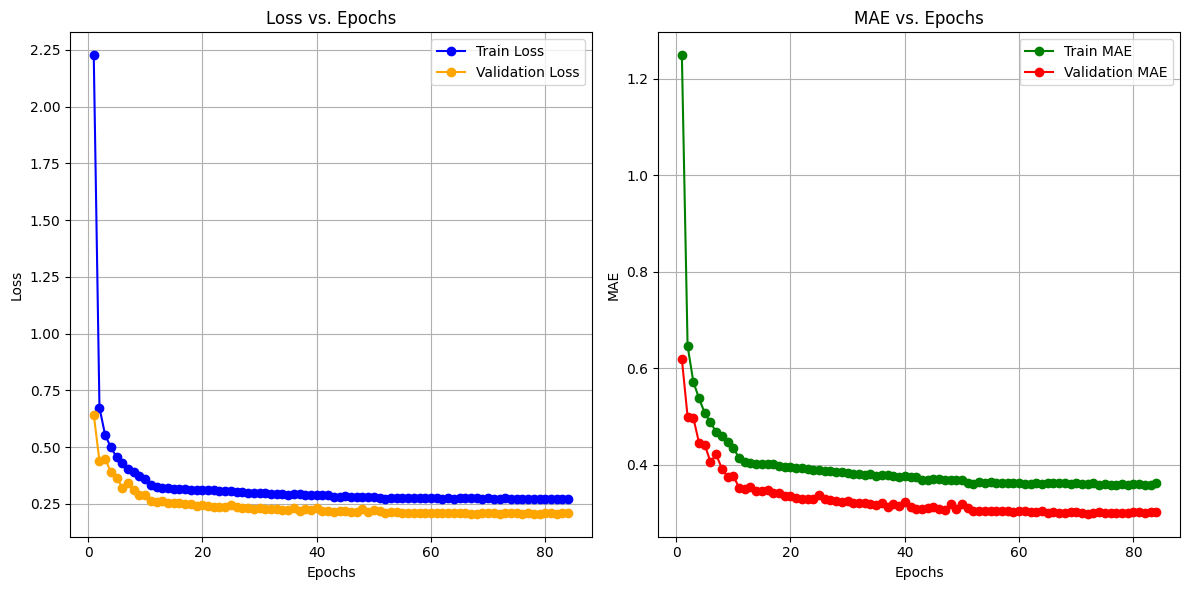

In [21]:
plot_history(history)

## Saving the best model

In [22]:
import pickle
os.makedirs('saved_models', exist_ok = True)
torch.save(model, f'saved_models/image_regressor_mae_{best_mae}_epoch_{epoch}.pth')
torch.save(model.state_dict(), f'saved_models/image_regressor_wts_mae_{best_mae:.4f}_epoch_{epoch}.pth')

with open('saved_models/train_history.pkl', 'wb') as f:
    pickle.dump(history, f)

## Evaluating on the Testset

In [23]:
testset = LoadDataset(
    test_csv,
    root_path,
    transforms=transforms['test'],
    cache_strategy = CacheStrategy.NO_CACHE
)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

print('Testset Size: ', len(testset), 'images')

Testset Size:  1010 images


In [24]:
eval_loss, eval_mae = evaluate_model(model, criterion , testloader)

100%|██████████| 8/8 [00:10<00:00,  1.27s/it]

Evaluation Loss: 0.1657 Evaluation MAE: 0.2462
